In [185]:
import numpy as np
import pandas as pd

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = stopwords.words('english')

In [16]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [17]:
stemmer = SnowballStemmer("english")

In [91]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    return filtered_tokens

In [20]:
df = pd.read_csv('SecDef_Speeches.csv')

In [92]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in df.speech:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [93]:
vocab = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab.shape[0]) + ' items in our vocabulary.')

There are 302045 items in our vocabulary.


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.speech) #fit the vectorizer to speeches

print(tfidf_matrix.shape)

CPU times: user 11.3 s, sys: 61.6 ms, total: 11.3 s
Wall time: 11.3 s
(204, 1593)


In [124]:
terms = tfidf_vectorizer.get_feature_names()

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [202]:
from sklearn.cluster import KMeans

num_clusters = 12

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 8.35 s, sys: 1.6 s, total: 9.95 s
Wall time: 2.57 s


In [203]:
df['cluster'] = clusters

In [204]:
df.groupby('cluster')['cluster'].count()

cluster
0     13
1     23
2     12
3     52
4     30
5     30
6      3
7      8
8     18
9      4
10     4
11     7
Name: cluster, dtype: int64

In [205]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [206]:
print("{0}Top terms per cluster:{1}".format(color.BOLD,color.END))
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("{0}Cluster {1} Words:{2}".format(color.BLUE + color.BOLD, i, color.END))
    
    for ind in order_centroids[i, :10]:
        word = str(vocab.loc[terms[ind].split(' ')].values.tolist()[0][0])
        print('\t-{0}'.format(word))
    print('')
    
    print("{0}Cluster {1} Speech Titles:\n{2}".format(color.GREEN + color.BOLD, i, color.END))
    titles = df[df['cluster'] == i].title
    for title in titles[:10]:
        print('\t- {0}'.format(title[:100]))
    print('\n\n')
    
print('\n')

Top terms per cluster:

Cluster 0 Words:
	-innovative
	-technologies
	-companies
	-board
	-things
	-investing
	-america
	-business
	-commercials
	-silicon

Cluster 0 Speech Titles:

	- Remarks Announcing a New Manufacturing Innovation Institute in Cambridge, Massachusetts
	- Remarks on "The Path to an Innovative Future for Defense" (CSIS Third Offset Strategy Conference)
	- Remarks at DARPA's "Wait, What?" Future Technology Forum
	- Remarks at the World Economic Forum dinner presenting the Secretary of Defense IDEAS Award to Dr. Wi
	- Remarks Announcing a New Manufacturing Innovation Institute in Silicon Valley
	- Remarks Announcing a DIUx Outpost in Austin, Texas
	- Remarks at Defense One Tech Summit
	- Remarks at the First Meeting of the Defense Innovation Board
	- Remarks to Seattle-area Technology, Business, Community, and Military Leaders
	- Drell Lecture: "Rewiring the Pentagon: Charting a New Path on Innovation and Cybersecurity" (Stanfor



Cluster 1 Words:
	-isil
	-campaigns
	

In [207]:
%time X = MinMaxScaler().fit_transform(tfidf_matrix.toarray())

CPU times: user 5.08 ms, sys: 2.24 ms, total: 7.32 ms
Wall time: 5.72 ms


In [208]:
%time X = PCA(n_components=2).fit_transform(X)

CPU times: user 45 ms, sys: 6.65 ms, total: 51.6 ms
Wall time: 14.7 ms


In [209]:
X.shape

(204, 2)

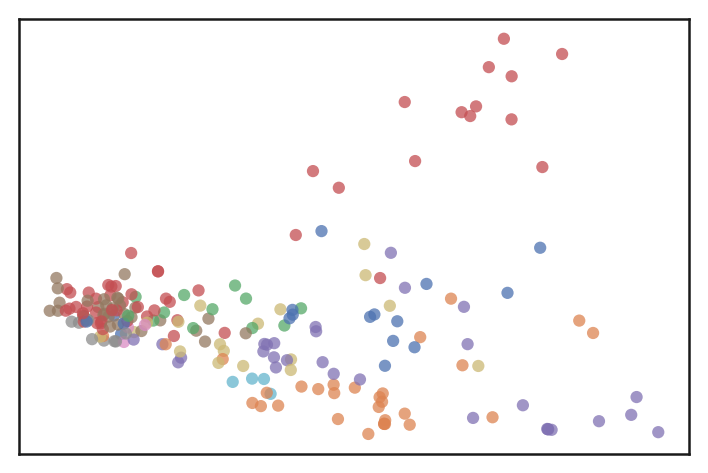

In [210]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'marker': 'o', 'alpha' : 0.75, 's' : 150, 'linewidths':0}

labels = clusters
end_time = time.time()
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(X.T[0], X.T[1], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()